In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
#import gdown
from zipfile import ZipFile

In [25]:
dataset = keras.utils.image_dataset_from_directory(
    "./dataset2/abstract_images/", label_mode=None, image_size=(64, 64), batch_size=64
)
dataset = dataset.map(lambda x: x / 255.0)

Found 2872 files belonging to 1 classes.


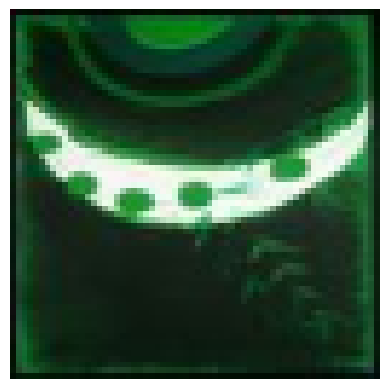

In [26]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [27]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)            

In [28]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 256)       0 

In [29]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [30]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("./GANimages/generated_img_%03d_%d.png" % (epoch, i))

In [31]:
epochs = 150  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)


Epoch 1/150
45/45 [==============================] - 49s 1s/step - d_loss: 0.5442 - g_loss: 0.9628
Epoch 2/150
45/45 [==============================] - 97s 2s/step - d_loss: 0.7710 - g_loss: 0.8950
Epoch 3/150
45/45 [==============================] - 51s 1s/step - d_loss: 0.4366 - g_loss: 1.2040
Epoch 4/150
45/45 [==============================] - 29s 638ms/step - d_loss: 0.6898 - g_loss: 1.6678
Epoch 5/150
45/45 [==============================] - 29s 640ms/step - d_loss: 0.8534 - g_loss: 1.9796
Epoch 6/150
45/45 [==============================] - 30s 656ms/step - d_loss: 0.1230 - g_loss: 3.9855
Epoch 7/150
45/45 [==============================] - 29s 646ms/step - d_loss: 0.2673 - g_loss: 3.2878
Epoch 8/150
45/45 [==============================] - 29s 650ms/step - d_loss: 0.7168 - g_loss: 1.3821
Epoch 9/150
45/45 [==============================] - 32s 719ms/step - d_loss: 0.7228 - g_loss: 0.9407
Epoch 10/150
45/45 [==============================] - 31s 685ms/step - d_loss: 0.7527 - g_l

In [32]:
generator.save("abstract_art_GAN")

INFO:tensorflow:Assets written to: abstract_art_GAN\assets


INFO:tensorflow:Assets written to: abstract_art_GAN\assets


In [108]:
model = keras.models.load_model("sunflower_GAN")

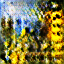

In [124]:
for i in range(50):
    random_latent_vectors = tf.random.normal(shape=(1, 128))
    generated_images = model(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    img = keras.preprocessing.image.array_to_img(generated_images[0])
    img.save("./GAN sunflower_results/generated_img_%d.png" % (i))